In [67]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import norm

sns.set_context("talk")

In [ ]:
%%bash

dx download -f data/supplementary_dataset_11_full_constraint_metrics.tsv -o ../data/

In [3]:
df = pd.read_csv("../outputs/expected_variants_stats_no_cpg.tsv", sep="\t")
df = df[["enst","csq","n_pos","prop_exp","n_exp","prop_obs","n_obs","oe","oe_diff","z","p"]]

In [4]:
df = df.set_index(["enst","csq"]).unstack("csq")
df.columns = df.columns.swaplevel(0,1)
df.sort_index(axis=1, level=0, inplace=True)

In [5]:
df.shape

(19623, 27)

In [6]:
pli = pd.read_csv("../data/supplementary_dataset_11_full_constraint_metrics.tsv", sep="\t")
pli = pli.set_index("transcript")

In [7]:
df = df.join(pli[["pLI", "oe_lof_upper"]], how="left")

/tmp/ipykernel_391/4184005028.py:1: FutureWarning: merging between different levels is deprecated and will be removed in a future version. (2 levels on the left, 1 on the right)
  df = df.join(pli[["pLI", "oe_lof_upper"]], how="left")


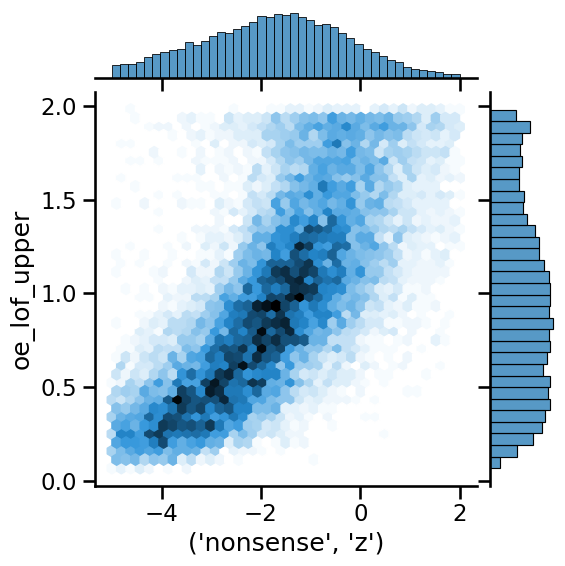

In [8]:
g = sns.jointplot(data=df[df["nonsense", "z"].between(-5,2)],
            x=("nonsense","z"),
            y="oe_lof_upper",
            kind="hex",
                 )

In [9]:
m1 = df["synonymous","n_obs"] > 10
m2 = df["synonymous","z"] >= -1
m3 = df["missense","n_obs"] > 10

df = df[m1 & m2 & m3]
df.shape

(14398, 29)

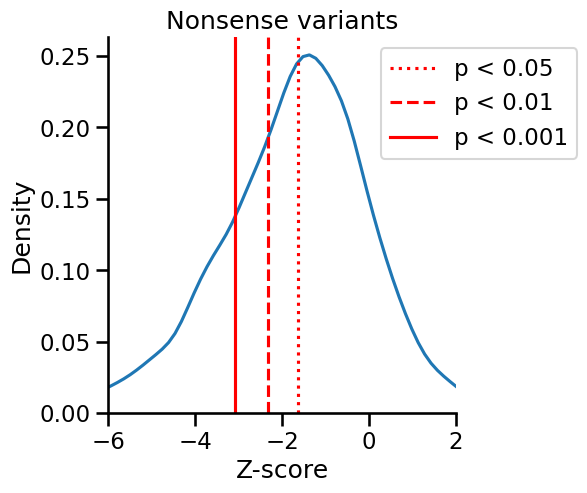

In [75]:
g = sns.displot(kind="kde",
                data=df,
                x=("nonsense","z")
               )
g.set(xlim=(-6,2),
      title="Nonsense variants",
      xlabel="Z-score",
     )

plt.axvline(x=-1.645, color="r", linestyle=":", label = "p < 0.05")
plt.axvline(x=-2.326, color="r", linestyle="--", label = "p < 0.01")
plt.axvline(x=-3.09, color="r", linestyle="-", label = "p < 0.001")

plt.legend(bbox_to_anchor = (0.75, 1), loc = 'upper left')


In [34]:
p_vals = df[[("nonsense","n_obs"), ("nonsense","p")]].copy()
p_vals.columns = ["n_obs","p"]
p_vals["p_bin"] = pd.cut(p_vals["p"], bins=[0,0.001,0.01,0.05,1])
p_stats = p_vals.groupby("p_bin").agg({"p":"count"})
p_stats["none_observed"] = p_vals.groupby("p_bin")["n_obs"].apply(lambda x: (x==0).sum())
p_stats

,p,none_observed
p_bin,,
"(0.0, 0.001]",3039,250
"(0.001, 0.01]",1814,129
"(0.01, 0.05]",2178,140
"(0.05, 1.0]",7367,47
